In [478]:
import warnings
warnings.filterwarnings("ignore")

In [479]:
import numpy as np
import pandas as pd
from tvDatafeed import TvDatafeed, Interval
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import mapie

In [480]:
username = ''
password = ''

tv = TvDatafeed(username, password)

ERROR:tvDatafeed.main:error while signin


In [481]:
data = tv.get_hist(symbol='ethusdt',exchange='BINANCE',interval=Interval.in_15_minute,n_bars=100000)

In [482]:
data.head()

,symbol,open,high,low,close,volume
datetime,,,,,,
2024-07-01 07:00:00,BINANCE:ethusdt,3438.16,3440.00,3432.55,3435.74,1909.6668
2024-07-01 07:15:00,BINANCE:ethusdt,3435.74,3442.46,3435.02,3440.04,1486.3507
2024-07-01 07:30:00,BINANCE:ethusdt,3440.04,3444.74,3437.81,3441.63,1309.2402
2024-07-01 07:45:00,BINANCE:ethusdt,3441.62,3445.41,3439.54,3443.02,2108.7336
2024-07-01 08:00:00,BINANCE:ethusdt,3443.02,3490.50,3440.50,3490.48,15107.5772


In [483]:
X = data['close'].values
X = X.astype('float32')
# X = X.reshape(-1,1)

In [484]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1))

In [485]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train, test = X[0:train_size,:], X[train_size:len(X),:]

In [486]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=3):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 60
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [487]:
trainX = trainX.reshape(trainX.shape[0], 60)

In [488]:
mod1 = XGBRegressor(learning_rate=0.1)

In [489]:
trainY.shape

(5598,)

In [490]:
mod1.fit(trainX,trainY)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [491]:
prediction = mod1.predict(testX)
prediction = scaler.inverse_transform(prediction.reshape(-1,1))

In [492]:
len(prediction)

1354

In [493]:
train = data[:train_size + 60 + 1]
test = data[train_size + 60 + 1::]
test['Prediction'] = prediction

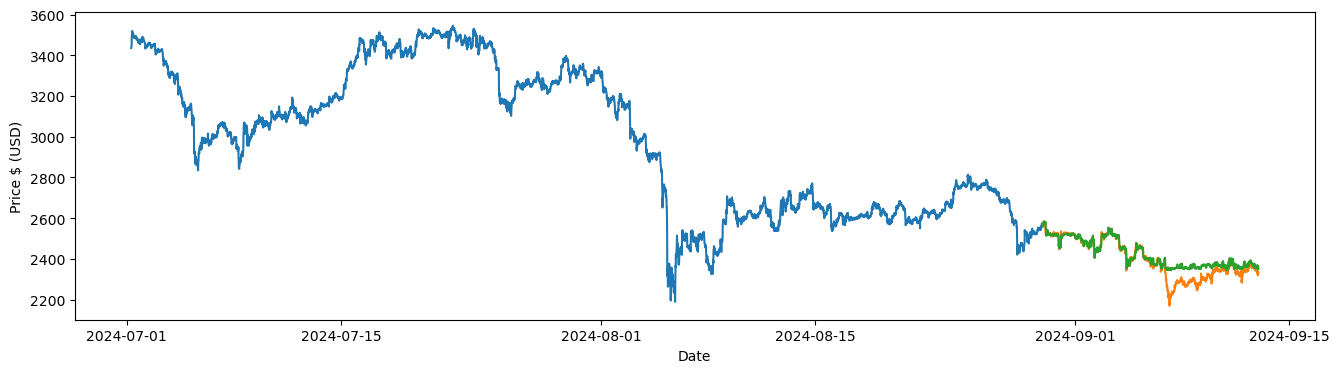

In [494]:
plt.figure(figsize=(16, 4))
plt.xlabel('Date')
plt.ylabel('Price $ (USD)')
plt.plot(train['close'])
plt.plot(test[['close', 'Prediction']])

In [495]:
np.mean(np.abs(test['close'] - test['Prediction']))

26.40733899701117

In [496]:
trade_df = test[['close','Prediction','open']]
trade_df['action'] = np.where(trade_df.open>trade_df.Prediction,'sell','buy')
trade_df['gp'] = np.where(trade_df.action=='buy',(trade_df.close-trade_df.open)/trade_df.open,(trade_df.open-trade_df.close)/trade_df.close)
trade_df = trade_df.iloc[1:]

trade_df

,close,Prediction,open,action,gp
datetime,,,,,
2024-08-29 21:15:00,2564.79,2572.802734,2574.34,sell,0.003724
2024-08-29 21:30:00,2573.55,2577.939453,2564.80,buy,0.003412
2024-08-29 21:45:00,2569.56,2570.515137,2573.55,sell,0.001553
2024-08-29 22:00:00,2575.49,2573.327637,2569.55,buy,0.002312
2024-08-29 22:15:00,2583.01,2570.515137,2575.49,sell,-0.002911
...,...,...,...,...,...
2024-09-12 22:15:00,2319.00,2347.927979,2336.28,buy,-0.007396
2024-09-12 22:30:00,2320.26,2350.306396,2319.00,buy,0.000543
2024-09-12 22:45:00,2323.20,2350.423340,2320.25,buy,0.001271


In [497]:
mod1.predict(X[-60:].reshape(1,-1))

array([0.13461097], dtype=float32)

In [498]:
scaler.inverse_transform(np.array([0.5261171]).reshape(-1,1))

array([[2893.56573018]])

In [499]:
var =[]
for i in range(len(trade_df.gp.values)):
    var.append(np.quantile(trade_df.gp.iloc[:i+1],q=0.05))

cvar = []
for i in range(len(var)):
    cvar.append(np.mean(var[:i]))

In [500]:
trade_df['VaR'] = var
cvar[0] = var[0]
trade_df['CVaR'] = cvar
trade_df['E[R]'] = np.where(trade_df.action=='buy',(trade_df.Prediction - trade_df.open)/trade_df.open,(-trade_df.Prediction + trade_df.open)/trade_df.Prediction)

trade_df['analysis'] = np.where(trade_df.gp > trade_df['E[R]'],'bad RR','Good RR')
trade_df

,close,Prediction,open,action,gp,VaR,CVaR,E[R],analysis
datetime,,,,,,,,,
2024-08-29 21:15:00,2564.79,2572.802734,2574.34,sell,0.003724,0.003724,0.003724,0.000598,bad RR
2024-08-29 21:30:00,2573.55,2577.939453,2564.80,buy,0.003412,0.003427,0.003724,0.005123,Good RR
2024-08-29 21:45:00,2569.56,2570.515137,2573.55,sell,0.001553,0.001739,0.003575,0.001181,bad RR
2024-08-29 22:00:00,2575.49,2573.327637,2569.55,buy,0.002312,0.001667,0.002963,0.001470,bad RR
2024-08-29 22:15:00,2583.01,2570.515137,2575.49,sell,-0.002911,-0.002019,0.002639,0.001935,Good RR
...,...,...,...,...,...,...,...,...,...
2024-09-12 22:15:00,2319.00,2347.927979,2336.28,buy,-0.007396,-0.004781,-0.004483,0.004986,Good RR
2024-09-12 22:30:00,2320.26,2350.306396,2319.00,buy,0.000543,-0.004780,-0.004483,0.013500,Good RR
2024-09-12 22:45:00,2323.20,2350.423340,2320.25,buy,0.001271,-0.004779,-0.004483,0.013004,Good RR


In [501]:
gp_var = []
for i in range(len(trade_df)):
    if trade_df.gp[i] > trade_df.VaR[i]:
        gp_var.append(trade_df.gp[i])
    else:
        gp_var.append(trade_df.VaR[i])

In [502]:
gp_cvar = []
for i in range(len(trade_df)):
    if trade_df.gp[i] > trade_df.CVaR[i]:
        gp_cvar.append(trade_df.gp[i])
    else:
        gp_cvar.append(trade_df.CVaR[i])

In [503]:
capital = 10000
for i in trade_df.gp.values:
    capital*=(1+i)
print(capital)

10227.214040892151


(array([  2., 169., 468., 558., 121.,  20.,  11.,   2.,   0.,   2.]),
 array([-8.11919525e-03, -5.38963660e-03, -2.66007794e-03,  6.94807094e-05,
         2.79903936e-03,  5.52859802e-03,  8.25815667e-03,  1.09877153e-02,
         1.37172740e-02,  1.64468326e-02,  1.91763913e-02]),
 <BarContainer object of 10 artists>)

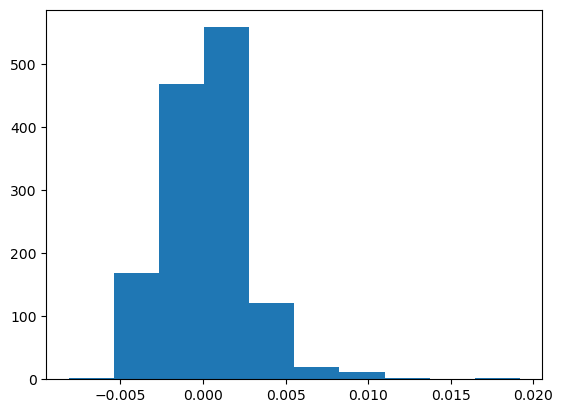

In [504]:
plt.hist(gp_var)

In [505]:
capital = 10000
for i in gp_var:
    capital*=(1+i)
print(capital)

12999.508494822912


In [506]:
capital = 10000
for i in gp_cvar:
    capital*=(1+i)
print(capital)

13862.702486417493


In [507]:
trade_df.tail()

,close,Prediction,open,action,gp,VaR,CVaR,E[R],analysis
datetime,,,,,,,,,
2024-09-12 22:15:00,2319.00,2347.927979,2336.28,buy,-0.007396,-0.004781,-0.004483,0.004986,Good RR
2024-09-12 22:30:00,2320.26,2350.306396,2319.00,buy,0.000543,-0.004780,-0.004483,0.013500,Good RR
2024-09-12 22:45:00,2323.20,2350.423340,2320.25,buy,0.001271,-0.004779,-0.004483,0.013004,Good RR
2024-09-12 23:00:00,2330.61,2350.164062,2323.20,buy,0.003190,-0.004778,-0.004484,0.011606,Good RR
2024-09-12 23:15:00,2332.48,2355.099854,2330.68,buy,0.000772,-0.004777,-0.004484,0.010478,Good RR


In [508]:
trade_df.tail(1).open*(1+trade_df.tail(1).VaR)

datetime
2024-09-12 23:15:00    2319.547357
dtype: float64

In [509]:
trade_df.tail(1).open*(1+trade_df.tail(1).CVaR)

datetime
2024-09-12 23:15:00    2320.229422
dtype: float64

In [510]:
trade_df.groupby('action').count()

,close,Prediction,open,gp,VaR,CVaR,E[R],analysis
action,,,,,,,,
buy,955,955,955,955,955,955,955,955
sell,398,398,398,398,398,398,398,398


In [511]:
trade_df.groupby('analysis').count()

,close,Prediction,open,action,gp,VaR,CVaR,E[R]
analysis,,,,,,,,
Good RR,1188,1188,1188,1188,1188,1188,1188,1188
bad RR,165,165,165,165,165,165,165,165


In [512]:
2311.49*(1-0.5/100)

2299.93255

In [513]:
len(gp_var)

1353

In [514]:
sum(gp_var)*100

26.696174984457734

In [515]:
np.mean(gp_var)*100

0.01973109754948835

In [516]:
np.std(gp_var)*100

0.26126318013029104